[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/porterjenkins/byu-cs474/blob/master/lab2_modules_training.ipynb)

# Deep Learning Part 2: Modules and the Training Pipeline
___

In this lab, we will be utilizing PyTorch modules to create neural networks, which we will use to solve a simple nonlinear regression problem. This will guide you through the deep learning training and validation loops which you will use in some form in every deep learning project.

In [1]:
import torch
import torch.nn as nn # Contains torch modules (network layers)
import torch.nn.functional as F # Contains stateless functional versions of modules

import matplotlib.pyplot as plt

In order to have reproducible results, we'll set the random seed. Because cells in notebooks can be run in any order, we'll need to set the seed multiple times: whenever the cell uses random operations. If you were to run your code in a script, you could just set the seed at the top.

In [2]:
torch.manual_seed(0) # Sets random seed for all PyTorch operations

---
### GPUs and Cuda
Generally, as programmers, we run everything on the CPU.
CPUs are designed to perform all sorts of calculations, but they are very slow for linear algebra tensor operations.
The GPU was designed to perform efficient math on large tensors (originally for rendering graphics).
Because deep learning is all tensor math, we can use the GPU to speed up our networks!
While you can do all labs on the CPU, training and validation will be very slow, so we recommend using the GPU.

Cuda is the library used to interact with Nvidia GPUs.
Google Colab and Kaggle offer free GPU usage (with some limitations) if you don't have a CUDA-compatible GPU.

**To use the GPU on Colab go to 'Runtime' at the top and then click 'Change runtime type'.**
Execute the cell below and make sure cuda is available.

In [3]:
print(f"Cuda is available: {torch.cuda.is_available()}")

Cuda is available: True


We can check to see what device (`cpu` or `cuda`) a tensors is on by looking at its `.device` variable.
Go ahead a print out what device `a` is on.

In [4]:
a = torch.tensor(1)

a.device

device(type='cpu')

By default all tensors start on the CPU.
To put a device on the GPU you can use the `.cuda()` function. Go ahead and put `a` on the GPU by using `a = a.cuda()` and print out the device.

*Note: `.cuda()` returns a COPY of the tensor so assignment is necessary.*

In [5]:
a = a.cuda()

assert str(a.device) == 'cuda:0'

Now that our tensor is on the GPU, every operation we perform with it will be on the GPU and the resulting tensors will also be on the GPU.

In [6]:
b = a+1
print(b)

tensor(2, device='cuda:0')


PyTorch makes using the GPU easy and almost invisible. This makes it easy to forget which device your tensor is on.

You can only perform tensor operations with tensors on the same device. If you try to do an operation between tensors on the CPU and GPU (or between different GPUs) you will get the following error:

In [7]:
# NOTE: This code SHOULD throw an error (if cuda is available)
b_cpu = torch.ones(1)
b_gpu = torch.ones(1).cuda()
print('Adding two tensors on the GPU gives us a GPU tensor:')
print(a + b_gpu)
print('Adding two tensors on different devices gives us this error:')
print(a + b_cpu)

Adding two tensors on the GPU gives us a GPU tensor:
tensor([2.], device='cuda:0')
Adding two tensors on different devices gives us this error:


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

If you want to put a tensor back on the CPU you can use the `.cpu()` function. Go ahead and put `a` on the CPU and print out the device.

*Note: `.cpu()` returns a COPY of the tensor so assignment is necessary.*

In [8]:
a = a.cpu()

assert str(a.device) == "cpu"

Only PyTorch operates on the GPU. Some operations, like printing the tensor, automatically copies the tensor on the CPU, but others, like `.numpy()` can't work unless the tensor is already on the CPU.

In [9]:
print('CPU tensor to NumPy works:')
print(a.cpu().numpy())
print('GPU tensor to NumPy fails:')
print(a.cuda().numpy())

CPU tensor to NumPy works:
1
GPU tensor to NumPy fails:


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

You can also put a tensor on a device using the `.to()` function.
First create a cuda `device` object with `device = torch.device('cuda')` (You can similarly create a cpu device with `torch.device('cpu')`).
Then set `a = a.to(device)`.

In [10]:
device = torch.device('cuda')

a = a.to(device)
device = None

a = a.to(device)

assert 'cuda' in str(a.device)

This is the best way to set tensors to a device since sometimes you may want to switch from being on the GPU to the CPU, for debugging purposes, and now instead of manually changing all `.cuda()` to `.cpu()` you just need to change the global variable `device` to be a `torch.device('cpu')` and all of your code will work automatically.

Pay close attention to what devices your tensors are on and you will avoid a lot of errors.

---

## Plotting Helper Functions

In [11]:
# Plots each (x,y) point, a prediction if a network is provided, and the ground-truth function if provided
def plot_data(x, y, network=None, gt_func=None, title=''):
    plt.plot(x, y, marker='.', linewidth=0, color='black') # plots the real points
    if network is not None:
        dense_x = torch.linspace(x.min(), x.max(), 1000).unsqueeze(1) # Evenly-spaced predicted x values
        with torch.no_grad(): # this will be explained in the `validation` function
            y_hat = network(dense_x.to(device)).cpu() # non-pytorch libraries like matplotlib need tensors to be on the CPU!
        plt.plot(dense_x, y_hat, label='network prediction')

        if gt_func is not None:
            plt.plot(dense_x, gt_func(dense_x), label='true function')
            plt.legend()

    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

def plot_loss(losses, title=''):
    plt.plot(losses)
    plt.xlabel("training step")
    plt.ylabel("MSE loss")
    plt.title(title)
    plt.show()

---

# Linear Regression

You will now solve a linear regression problem, like in lab 1.
If you recall from lab 1, solving a regression problem involved multiple iterations of the following steps:
1. Applying the slope formula, $Wx + b$, to get our predicted output
2. Getting our loss
3. Calling backward
4. Updating our slope and intercept tensors with their gradients

We will be doing the exact same thing, but we will now do it in a more PyTorch-specific way, using `torch.nn`.

PyTorch's neural network library `torch.nn` has lots of functionality for building neural networks.
There are two important classes in the `nn` library: `Parameter` and `Module`.
A `Parameter` is just a `Tensor` with a little extra functionality.
A `Module` is a class that can contains `Parameter`s (e.g. weights) and other `Module`s and performs a function on them through the `Module.forward()` function.
In PyTorch neural networks inherit the `Module` class and it will be composed of layers that also inherit `Module` class.

Let's build a dummy module below to see some of the functionality of a `Module` class.

In [13]:
class DummyModule(nn.Module):
    def __init__(self):
        super().__init__()  # Initialize the base class

        # Create two parameters with the specified weights
        self.parameter1 = nn.Parameter(torch.tensor([1., 1.]))  # Parameter with weights [1., 1.]
        self.parameter2 = nn.Parameter(torch.tensor([2., 2.]))  # Parameter with weights [2., 2.]

    def forward(self, x):
        # Add parameter1 to x and multiply by parameter2
        return (x + self.parameter1) * self.parameter2

# Instantiate the DummyModule
dummy = DummyModule()

Print out whether `dummy.parameter1` requires grad or not.

In [14]:
# Check if parameter1 requires gradient
print(f"Does parameter1 require gradients? {dummy.parameter1.requires_grad}")


Does parameter1 require gradients? True


By default a `Parameter` has `.requires_grad` set to true.

Let's see the parameters in `dummy`; call `dummy.parameters()` and output its contents.

*Note: `.parameters()` returns a generator so in order to see its contents you need to either convert it to a list, e.g. `list()`, or iterate through it with a for loop.*

In [15]:
# Convert the generator to a list and print the parameters
params = list(dummy.parameters())
print(params)


[Parameter containing:
tensor([1., 1.], requires_grad=True), Parameter containing:
tensor([2., 2.], requires_grad=True)]


We can even view each parameter's name by calling `dummy.named_parameters()`. Call `dummy.named_parameters()` below and output its contents.

In [16]:
# Iterate through the named parameters generator and print each name and parameter
for name, param in dummy.named_parameters():
    print(f"Name: {name}, Parameter: {param}")


Name: parameter1, Parameter: Parameter containing:
tensor([1., 1.], requires_grad=True)
Name: parameter2, Parameter: Parameter containing:
tensor([2., 2.], requires_grad=True)


Now use the `.forward()` function, however do not call `.forward()` directly, instead you should use the `.__call__()` function.
PyTorch has extra functionality added in the `.__call__()` function, mainly adding hooks, and so you should **never** call `.forward()` directly.
Execute the cell below as an example of what we mean.

In [17]:
class Foward_vs_Call_Example:
    def __call__(self, x):
        print('Do something important before .foward()')
        self.forward(x)
        print('Do something important after .forward()')

    def forward(self, x):
        print(f'forward function using {x}')

example = Foward_vs_Call_Example()
x = "tensor"

Call `example.forward()` and pass in `x`.

In [18]:
example.forward(x)

forward function using tensor


Now call `example.__call__()` and pass in `x`. You shouldn't explicitly write `example.__call__()`, running `example()` is the same as calling `example.__call__()`.

In [20]:
example(x)

Do something important before .foward()
forward function using tensor
Do something important after .forward()


Using the `.__call__()` function, execute `DummyModule`'s `forward()` functionality to execute operations on tensors `a` and `b` below.

In [21]:
a = torch.tensor([1., 1.])
b = torch.tensor([-1., 2.])

# Execute DummyModule forward on tensor a
answer_a = dummy(a)  # This calls the .__call__() method

# Ensure the result is correct
assert torch.equal(answer_a, torch.tensor([4., 4.]))
print(f"Result of DummyModule on a: {answer_a}")

# Execute DummyModule forward on tensor b
answer_b = dummy(b)  # This calls the .__call__() method

# Ensure the result is correct
assert torch.equal(answer_b, torch.tensor([0., 6.]))
print(f"Result of DummyModule on b: {answer_b}")

Result of DummyModule on a: tensor([4., 4.], grad_fn=<MulBackward0>)
Result of DummyModule on b: tensor([0., 6.], grad_fn=<MulBackward0>)


Another nice utility of a `Module` is that you can put all of its parameters on a device by using the `.to()` function.
Set `dummy = dummy.to(device)` and print out the devices that `parameter1` and `parameter2` are on to validate this is true.

In [22]:
dummy = dummy.to(device)

# Print the devices of the parameters
print(f"Device of parameter1: {dummy.parameter1.device}")
print(f"Device of parameter2: {dummy.parameter2.device}")

Device of parameter1: cpu
Device of parameter2: cpu


Now that you understand the `Parameter` and `Module` classes a little better, build a linear layer `Module` (called `LinearLayer`) so we can do linear regression.
The `LinearLayer` will perform an affine transformation, i.e. $Wx + b$.
However, the shape of `x` will be `(B, Z_in)`, where `B` is the 'batch size' and `Z_in` is our 'input feature size' and the expected shape of our output is `(B, Z_out)`, where `B` is the 'batch size' and `Z_out` is the 'output feature size', therefore, your `LinearLayer` should perform $xW$ matrix multiplication, since $(B \times Z_{in}) \cdot (Z_{in} \times Z_{out}) \rightarrow (B \times Z_{out})$, to ensure that the batch size remains in the 0th dimension.

Follow the TODOs down below.

```python
class LinearLayer(nn.Module):
    def __init__(self, input_feature_size, output_feature_size):
        # TODO 1: It is VERY IMPORTANT you add `super().__init__()` to all nn.Module constructors you create.
        # TODO 2: Initialize a self.weight Parameter with shape (input_feature_size, output_feature_size)
        # TODO 3: Use the nn.init.xavier_uniform_() function to set the weights in the self.weight
        # TODO 4: Initialize a self.bias Parameter with shape (output_feature_size,)
        # TODO 5: Use the nn.init.uniform_() function to set the weights in the self.bias between -1 and 1

    def forward(self, x):
        # TODO: Implement the affine transformation Wx + b correctly and return the output
```

You can find helpful resources and documentation on `nn.init.xavier_uniform_()` and `nn.init.uniform_()` online.

*Note: In PyTorch a function that ends with '_' will perform the operation inplace.*

In [23]:
class LinearLayer(nn.Module):
    def __init__(self, input_feature_size, output_feature_size):
        super().__init__()  # Initialize the parent nn.Module

        # TODO 2: Initialize a self.weight Parameter with shape (input_feature_size, output_feature_size)
        self.weight = nn.Parameter(torch.Tensor(input_feature_size, output_feature_size))

        # TODO 3: Use the nn.init.xavier_uniform_() function to set the weights in the self.weight
        nn.init.xavier_uniform_(self.weight)

        # TODO 4: Initialize a self.bias Parameter with shape (output_feature_size,)
        self.bias = nn.Parameter(torch.Tensor(output_feature_size))

        # TODO 5: Use the nn.init.uniform_() function to set the weights in the self.bias between -1 and 1
        nn.init.uniform_(self.bias, -1, 1)

    def forward(self, x):
        # TODO: Implement the affine transformation Wx + b correctly and return the output
        return torch.matmul(x, self.weight) + self.bias

Execute the code below to assert that your functionality works correctly.

In [24]:
def test_LinearLayer():
    x = [[0, 0, 0],
         [1, 1, 1],
         [2, 2, 2],
         [0, 1, 2]]
    x = torch.tensor(x, dtype=torch.float32)

    batch_size, in_features = x.shape
    out_features = 2

    layer = LinearLayer(in_features, out_features)
    y = layer(x)
    assert y.shape == torch.Size([batch_size, out_features])

    layer.weight.data = torch.tensor([[2, 0],[0, 1], [1, 1]], dtype=torch.float32)
    layer.bias.data = torch.tensor([0, 1], dtype=torch.float32)

    y = layer(x)
    assert torch.equal(y, torch.tensor([[0, 1], [3, 3], [6, 5], [2, 4]]))

test_LinearLayer()

Now that we have `LinearLayer` built, let's create an `SGD` optimizer that will update the parameters in `LinearLayer`.

In [26]:
class SGD:
    def __init__(self, parameters, lr):
        # Store parameters as a list to handle both lists and generators
        self.parameters = list(parameters)

        # Store the learning rate
        self.lr = lr

    def zero_grad(self):
        """
        Zero out all the gradients for each parameter
        """
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()

    def step(self):
        """
        Perform the gradient descent step for each parameter
        """
        for param in self.parameters:
            # Update parameters using the gradient and learning rate
            if param.grad is not None:
                param.data -= self.lr * param.grad

Execute the cell below to test that your implementation works correctly.

In [27]:
def test_sgd():
    linear_layer = LinearLayer(1, 1)
    linear_layer.weight.data = torch.tensor([[1.]])
    linear_layer.weight.grad = torch.tensor([[.5]])

    linear_layer.bias.data = torch.tensor([0.])
    linear_layer.bias.grad = torch.tensor([1.])

    optimizer = SGD(linear_layer.parameters(), .1)

    # TESTING STEP
    optimizer.step()
    assert torch.equal(linear_layer.weight, torch.tensor([[.95]]))
    assert torch.equal(linear_layer.bias, torch.tensor([-.1]))

    # TESTING ZERO_GRAD
    optimizer.zero_grad()
    assert linear_layer.weight.grad is None or torch.equal(linear_layer.weight.grad, torch.zeros_like(linear_layer.weight.grad))
    assert linear_layer.bias.grad is None or torch.equal(linear_layer.bias.grad, torch.zeros_like(linear_layer.bias.grad))

test_sgd()

Finally, implement the loss function necessary to train our network. We will use mean squared error (MSE):
$$\textrm{MSE}(\hat{y}, y) = \frac{1}{\lvert y \rvert} \sum_{k=0}^{\lvert y \rvert - 1} (\hat{y}_k - y_k)^2$$

Do **not** use a for loop in your implementation, use `torch.mean()` instead.
You can use `nn.functional.mse_loss()` to validate your implementation works.

In [29]:
def mse_loss(y_hat, y):
    # Compute the squared difference between y_hat and y
    squared_diff = (y_hat - y) ** 2

    # Return the mean of the squared differences
    return torch.mean(squared_diff)

Now that we have the necessary components to learn linear regression, let's generate some data.

In [30]:
torch.manual_seed(0)
# Creating a linear regression dataset
linear_x = (torch.rand(100, 1) - .5) * 10
linear_m = torch.randn(1)
linear_b = torch.randn(1)
linear_y = linear_m * linear_x + linear_b + torch.randn(100,1)*.01

print("True function: y = {:.4f}x + {:.4f}".format(linear_m.item(), linear_b.item()))

True function: y = 0.0627x + -0.7663


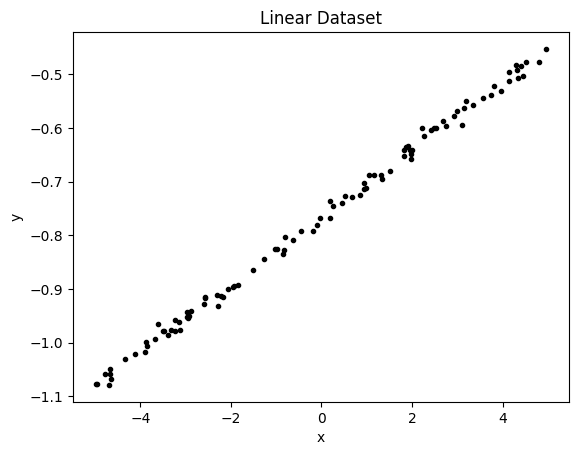

In [31]:
plot_data(linear_x, linear_y, title="Linear Dataset")

Now implement the following training function.
There are two things to note:
1. Because the loss $L$ has gradient information attached (remember the computation graph), do not blindly append $L$, otherwise we will continually create thousands of computation graphs and the data will never be freed. While calling `L.detach()` would avoid this issue, since we only care about the loss value, call `L.item()` which will return the loss as a float.
2. Other than in the comments we do not explicitly mention the SGD optimizer. It is implicit and therefore, you can either pass in the optimizer or initialize it inside the training loop. Passing it in is the preferred method, so we will opt for that.


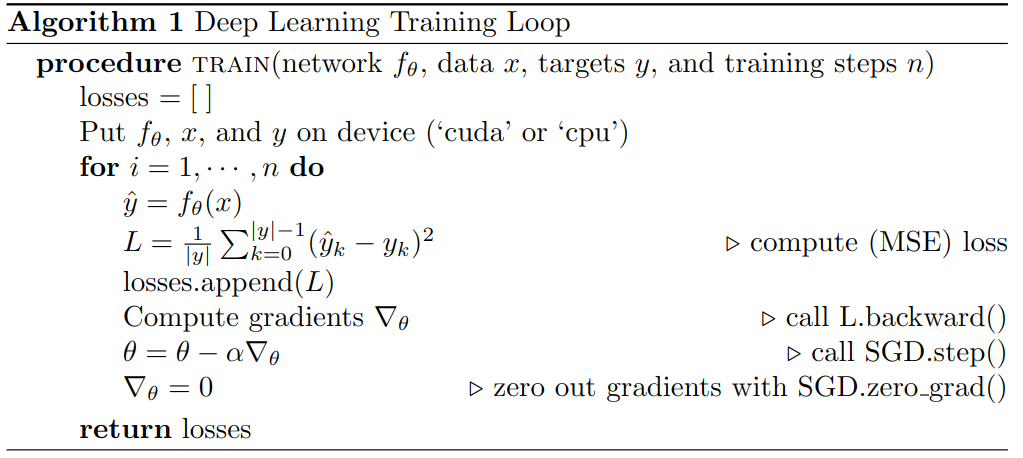

In [32]:
def train(network, optimizer, x, y, training_steps):
    # Loop through the number of training steps
    for step in range(training_steps):
        # Forward pass: compute predictions using the network
        y_hat = network(x)

        # Compute the MSE loss
        loss = mse_loss(y_hat, y)

        # Zero the gradients before the backward pass
        optimizer.zero_grad()

        # Backward pass: compute gradients of the loss with respect to parameters
        loss.backward()

        # Perform an optimization step (update the weights)
        optimizer.step()

        # Log the loss value (as a float) using .item() to avoid building computation graphs
        print(f"Step {step+1}/{training_steps}, Loss: {loss.item()}")


Now, we'll create a single-layer regression model. For the data to fit into the model, we must provide the correct `input_feature_size` parameter. For the prediction to match the true labels and fit into the loss function with the label, we must provide the correct `output_feature_size` parameter. In this case, we have a single x-value as an input and a single y-value as an output, so `input_feature_size=1` and `output_feature_size=1`.

Initialize a `LinearLayer` and a `SGD` optimizer (learning rate of .1) and train your network for 50 steps.

Step 1/50, Loss: 3.4434475898742676
Step 2/50, Loss: 2.2155418395996094
Step 3/50, Loss: 1.4256694316864014
Step 4/50, Loss: 0.9175095558166504
Step 5/50, Loss: 0.5905488729476929
Step 6/50, Loss: 0.38015028834342957
Step 7/50, Loss: 0.24474258720874786
Step 8/50, Loss: 0.1575864553451538
Step 9/50, Loss: 0.10148096084594727
Step 10/50, Loss: 0.0653592050075531
Step 11/50, Loss: 0.04210037738084793
Step 12/50, Loss: 0.027122091501951218
Step 13/50, Loss: 0.017475061118602753
Step 14/50, Loss: 0.011260912753641605
Step 15/50, Loss: 0.007257512770593166
Step 16/50, Loss: 0.004678015131503344
Step 17/50, Loss: 0.003015751950442791
Step 18/50, Loss: 0.0019444325007498264
Step 19/50, Loss: 0.0012538554146885872
Step 20/50, Loss: 0.0008086612797342241
Step 21/50, Loss: 0.0005216144490987062
Step 22/50, Loss: 0.00033650771365500987
Step 23/50, Loss: 0.0002171205560443923
Step 24/50, Loss: 0.0001401112967869267
Step 25/50, Loss: 9.042725287145004e-05
Step 26/50, Loss: 5.8372443163534626e-05
St

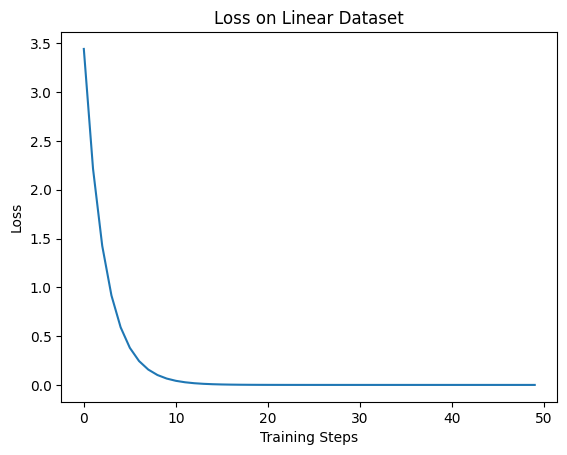

In [36]:
def plot_loss(train_losses, title="Training Loss"):
    plt.plot(train_losses)
    plt.title(title)
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.show()

# Create sample data: Single x-value as input and single y-value as output
x = torch.randn(100, 1)  # 100 samples with a single feature
y = 3 * x + 2  # Simple linear relationship (y = 3x + 2)

# TODO: Initialize a LinearLayer (input_feature_size=1, output_feature_size=1)
linear_network = LinearLayer(input_feature_size=1, output_feature_size=1)

# TODO: Initialize an SGD Optimizer with a learning rate of 0.1
optimizer = SGD(linear_network.parameters(), lr=0.1)

# Modify the train function to return the losses for plotting
def train_with_loss_tracking(network, optimizer, x, y, training_steps):
    train_losses = []
    for step in range(training_steps):
        y_hat = network(x)
        loss = mse_loss(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Store the loss value
        train_losses.append(loss.item())
        print(f"Step {step+1}/{training_steps}, Loss: {loss.item()}")
    return train_losses

# TODO: Train linear_network for 50 steps
train_losses = train_with_loss_tracking(linear_network, optimizer, x, y, training_steps=50)

# Plot the training loss
plot_loss(train_losses, title="Loss on Linear Dataset")


Your loss plot should be decreasing in a curve: it decreases very quickly at first and starts to level off.

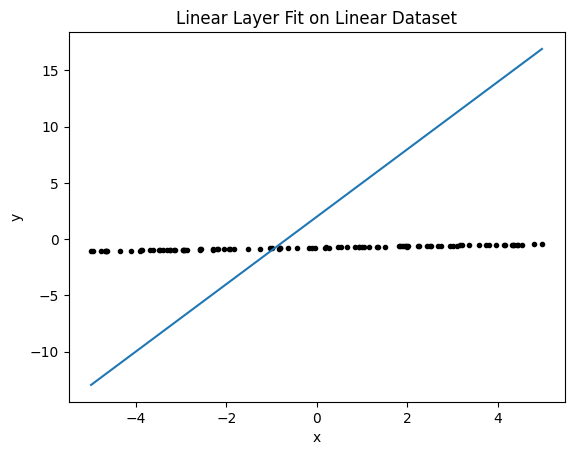

In [34]:
# Plot your fit on the data
plot_data(linear_x, linear_y, linear_network, title="Linear Layer Fit on Linear Dataset")

### Nonlinear Regression

Some problems cannot be effectively solved by a linear model. We can create more complex nonlinear models by stacking linear layers and nonlinear activation functions.

Here, we have a nonlinear function we'd like to approximate. Try to solve it with a one-layer linear model.

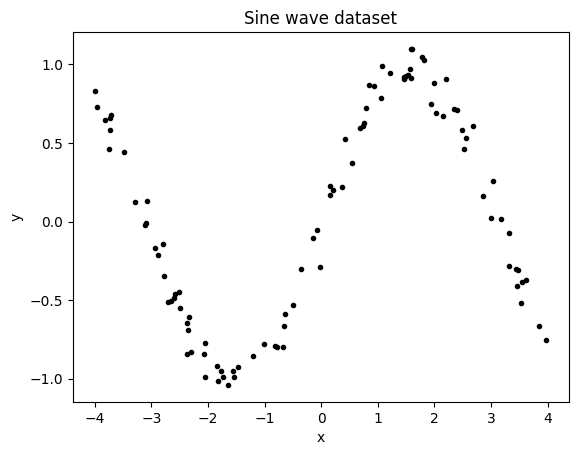

In [35]:
torch.manual_seed(0) # Sets random seed for all PyTorch operations
sine_x = torch.rand((100,1))*8 - 4
sine_y = torch.sin(sine_x) + torch.randn_like(sine_x)*.1 # the second part of the sum adds noise to the function

plot_data(sine_x, sine_y, title="Sine wave dataset")

Initialize a `LinearLayer` and a `SGD` optimizer (learning rate of .05) and train your network for 50 steps.

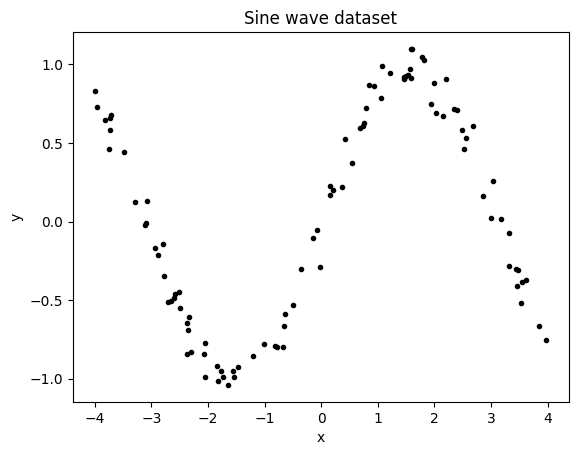

Step 1/50, Loss: 12.049487113952637
Step 2/50, Loss: 2.9754528999328613
Step 3/50, Loss: 1.1024531126022339
Step 4/50, Loss: 0.6911766529083252
Step 5/50, Loss: 0.5813170671463013
Step 6/50, Loss: 0.5374034643173218
Step 7/50, Loss: 0.5109266042709351
Step 8/50, Loss: 0.4913104176521301
Step 9/50, Loss: 0.47578585147857666
Step 10/50, Loss: 0.46328067779541016
Step 11/50, Loss: 0.4531623125076294
Step 12/50, Loss: 0.44496601819992065
Step 13/50, Loss: 0.43832480907440186
Step 14/50, Loss: 0.43294331431388855
Step 15/50, Loss: 0.42858248949050903
Step 16/50, Loss: 0.4250486493110657
Step 17/50, Loss: 0.42218512296676636
Step 18/50, Loss: 0.41986462473869324
Step 19/50, Loss: 0.417984277009964
Step 20/50, Loss: 0.4164605438709259
Step 21/50, Loss: 0.4152257442474365
Step 22/50, Loss: 0.41422516107559204
Step 23/50, Loss: 0.4134143888950348
Step 24/50, Loss: 0.41275733709335327
Step 25/50, Loss: 0.4122248888015747
Step 26/50, Loss: 0.41179344058036804
Step 27/50, Loss: 0.411443829536438
S

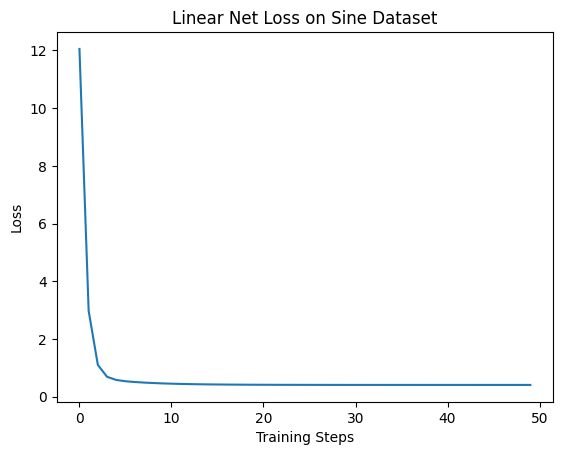

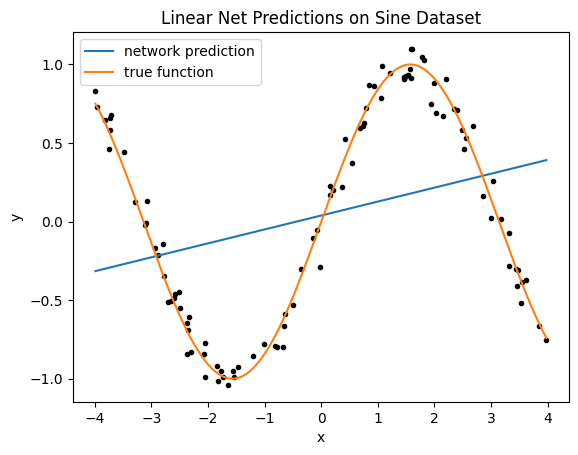

In [37]:
# Set random seed for reproducibility
torch.manual_seed(0)

# Generate sine wave data
sine_x = torch.rand((100, 1)) * 8 - 4  # 100 samples, each with one feature, values between -4 and 4
sine_y = torch.sin(sine_x) + torch.randn_like(sine_x) * 0.1  # Sine wave with noise

# Plot the sine wave dataset
plot_data(sine_x, sine_y, title="Sine wave dataset")

# TODO: Initialize a LinearLayer (input_feature_size=1, output_feature_size=1)
linear_network = LinearLayer(input_feature_size=1, output_feature_size=1)

# TODO: Initialize an SGD Optimizer with learning rate of 0.05
optimizer = SGD(linear_network.parameters(), lr=0.05)

# TODO: Train linear_network for 50 steps using your train function
train_losses = train_with_loss_tracking(linear_network, optimizer, sine_x, sine_y, training_steps=50)

# Plot the training losses
plot_loss(train_losses, "Linear Net Loss on Sine Dataset")

# Plot the predictions on the dataset
plot_data(sine_x, sine_y, linear_network, gt_func=torch.sin, title="Linear Net Predictions on Sine Dataset")


In [ ]:
print("Our network's trained prediction function is:")
print("y = {:.3f}x + {:.3f}".format(linear_network.weight.data.item(), linear_network.bias.data.item()))

A linear network can only create a linear prediction, which isn't very useful for complex problems. Let's create a deeper network with multiple layers called `StackedLinear`.
`StackedLinear` should have 3 `LinearLayer`s:
- Layer 1 should map tensors from `(B, Z_in)` to `(B, H)` where `H` is the hidden size.
- Layer 2 should map tensors from `(B, H)` to `(B, H)`.
- Layer 3 should map tensors from `(B, H)` to `(B, Z_out)`.

In [38]:
class StackedLinear(nn.Module):
    def __init__(self, input_feature_size, output_feature_size, hidden_size):
        super().__init__()

        # Create three linear layers:
        # Layer 1: (B, Z_in) -> (B, H)
        self.lin1 = LinearLayer(input_feature_size, hidden_size)

        # Layer 2: (B, H) -> (B, H)
        self.lin2 = LinearLayer(hidden_size, hidden_size)

        # Layer 3: (B, H) -> (B, Z_out)
        self.lin3 = LinearLayer(hidden_size, output_feature_size)

    def forward(self, x):
        # Pass x through self.lin1
        x = self.lin1(x)

        # Pass the output of self.lin1 into self.lin2
        x = self.lin2(x)

        # Pass the output of self.lin2 into self.lin3
        x = self.lin3(x)

        return x

To see some other functionality that a `Module` has, create a `StackedLinear` object called `stacked_net` and print out `stacked_net`

In [39]:
# Create an instance of the StackedLinear model
stacked_net = StackedLinear(input_feature_size=1, output_feature_size=1, hidden_size=10)

# Print the model to see its structure
print(stacked_net)

StackedLinear(
  (lin1): LinearLayer()
  (lin2): LinearLayer()
  (lin3): LinearLayer()
)


Printing out a `Module` is a simple way to see what the object contains.
Furthermore, `.parameters()` is recursive, so while we haven't define any `Parameter`s inside of `StackedLinear` because `LinearLayer` has some we get them when we call `.parameters()`.
Use `.named_parameters()` to print out the names of all the `Parameter`s in `stacked_net`.

In [40]:
# Print the names and values of all parameters in stacked_net
for name, param in stacked_net.named_parameters():
    print(f"Name: {name}, Parameter: {param}")

Name: lin1.weight, Parameter: Parameter containing:
tensor([[ 0.5964, -0.5994, -0.0530,  0.7306,  0.2668,  0.0209, -0.6400,  0.3659,
         -0.5261, -0.2096]], requires_grad=True)
Name: lin1.bias, Parameter: Parameter containing:
tensor([-0.3355, -0.1481,  0.0109,  0.8248,  0.1248,  0.8957,  0.6117, -0.6322,
         0.4485, -0.7069], requires_grad=True)
Name: lin2.weight, Parameter: Parameter containing:
tensor([[-0.2321,  0.1611,  0.1809,  0.4109, -0.1763,  0.0009,  0.2820, -0.5297,
          0.3960, -0.4529],
        [ 0.0075, -0.0931, -0.2885,  0.0724,  0.4529, -0.1601, -0.3252, -0.2026,
         -0.5429,  0.2472],
        [-0.2631, -0.3655, -0.3155,  0.3149,  0.2901,  0.4204,  0.1987, -0.1829,
         -0.1531,  0.1618],
        [ 0.4502,  0.1489, -0.2592, -0.2575, -0.5179,  0.1183, -0.3074, -0.4883,
          0.4803, -0.3557],
        [-0.0623,  0.1569,  0.0174, -0.3686, -0.4427,  0.4366,  0.0892,  0.4544,
         -0.1836,  0.1613],
        [-0.1253, -0.0244, -0.3336,  0.1852,

Now we can try to solve the nonlinear problem with our stacked network.
Initialize a `StackedLinear` (with hidden size set to 64) and a `SGD` optimizer (learning rate of .01) and train your network for 50 steps.

The `input_feature_size` and `output_feature_size` should be the same as for our one-layer linear network, since they are problem-dependent not network-dependent. `hidden_size` is a hyperparameter and one that you choose the value of. It determines the size of the tensors created as the input passes through the network layers (except for the final layer), so a higher `hidden_size` means your network has more parameters and can learn more complex functions. However, it also means your network has to perform more calculations with each pass.

Step 1/50, Loss: 0.7541537284851074
Step 2/50, Loss: 0.46336081624031067
Step 3/50, Loss: 0.4370974600315094
Step 4/50, Loss: 0.42893272638320923
Step 5/50, Loss: 0.4237266182899475
Step 6/50, Loss: 0.41992878913879395
Step 7/50, Loss: 0.4171997904777527
Step 8/50, Loss: 0.4151994287967682
Step 9/50, Loss: 0.4137592315673828
Step 10/50, Loss: 0.4127075672149658
Step 11/50, Loss: 0.4119494557380676
Step 12/50, Loss: 0.41139736771583557
Step 13/50, Loss: 0.41099900007247925
Step 14/50, Loss: 0.410709410905838
Step 15/50, Loss: 0.4105002284049988
Step 16/50, Loss: 0.4103483259677887
Step 17/50, Loss: 0.410238653421402
Step 18/50, Loss: 0.4101589322090149
Step 19/50, Loss: 0.4101013243198395
Step 20/50, Loss: 0.4100595712661743
Step 21/50, Loss: 0.4100293815135956
Step 22/50, Loss: 0.4100074768066406
Step 23/50, Loss: 0.40999165177345276
Step 24/50, Loss: 0.4099801778793335
Step 25/50, Loss: 0.40997183322906494
Step 26/50, Loss: 0.4099658131599426
Step 27/50, Loss: 0.40996143221855164
Step

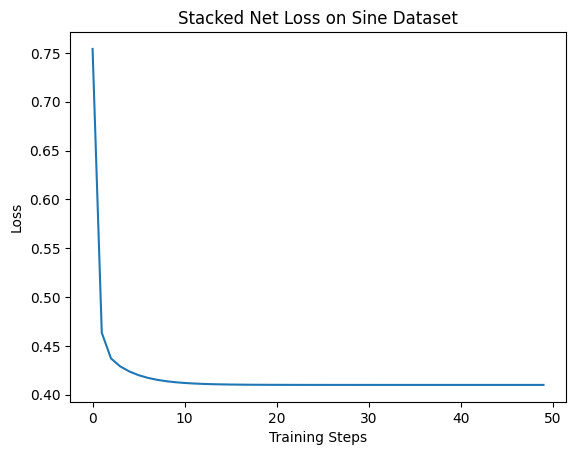

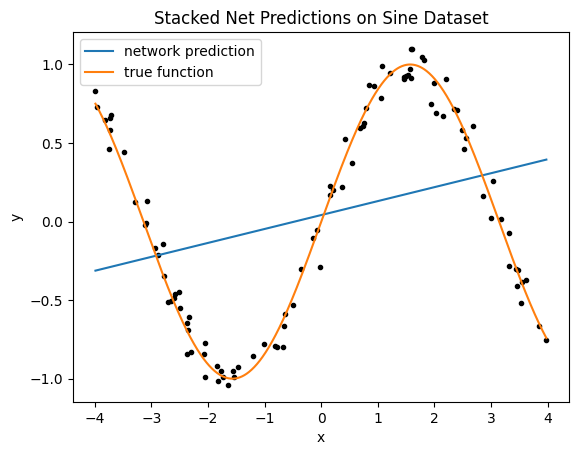

In [41]:
# Set random seed for reproducibility
torch.manual_seed(0)

# TODO: Initialize a StackedLinear (set hidden_size to 64) called stacked_net.
input_feature_size = 1  # Same as before
output_feature_size = 1  # Same as before
hidden_size = 64  # Hyperparameter

# Initialize the stacked network
stacked_net = StackedLinear(input_feature_size=input_feature_size, output_feature_size=output_feature_size, hidden_size=hidden_size)

# TODO: Initialize SGD optimizer with a learning rate of .01
optimizer = SGD(stacked_net.parameters(), lr=0.01)

# TODO: Train stacked_net for 50 steps and store training losses
train_losses = train_with_loss_tracking(stacked_net, optimizer, sine_x, sine_y, training_steps=50)

# Plot training losses
plot_loss(train_losses, "Stacked Net Loss on Sine Dataset")

# Plot fit on the data
plot_data(sine_x, sine_y, stacked_net, gt_func=torch.sin, title="Stacked Net Predictions on Sine Dataset")


What gives! The output is still linear! Stacking linear functions always gives us another linear function.
$$\begin{align}
& W_3(W_2(W_1x + b_1) + b_2) + b_3 \\
    = & W_3(W_2 W_1x + W_2 b_1 + b_2) + b_3 \\
    = & W_3 W_2 W_1x + W_3 W_2 b_1 + W_3 b_2 + b_3 \\
    = & (W_3 W_2 W_1) x + (W_3 W_2 b_1 + W_3 b_2 + b_3) \\
    = & Wx + b
\end{align}$$

So despite having a stacked network with more parameters, our `stacked_net` is functionally the same as our `linear_net`! Execute the code below to see.

With the distributive property, our 3-layer is equivalent to a 1-layer net that implements the following function:
	y = 0.089x + 0.042
We verify this by plotting this function:


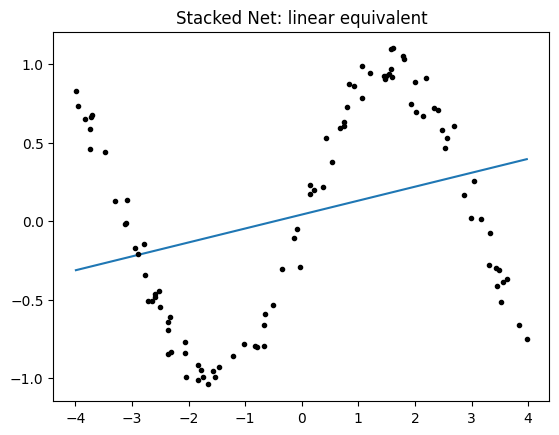

In [42]:
W1, b1 = stacked_net.lin1.weight.data.T, stacked_net.lin1.bias.data
W2, b2 = stacked_net.lin2.weight.data.T, stacked_net.lin2.bias.data
W3, b3 = stacked_net.lin3.weight.data.T, stacked_net.lin3.bias.data
M = (W3@W2@W1).item()
b = (W3@W2@b1 + W3@b2 + b3).item()
print("With the distributive property, our 3-layer is equivalent to a 1-layer net that implements the following function:")
print("\ty = {:.3f}x + {:.3f}".format(M, b))
print("We verify this by plotting this function:")

# Verify that this is the same as the prediction by plotting it instead of the network predictions
dense_x = torch.linspace(sine_x.min(), sine_x.max(), 1000).unsqueeze(1) # For dense prediction
with torch.no_grad():
    plt.plot(dense_x, M*dense_x+b)
plt.plot(sine_x, sine_y, linewidth=0, marker='.', color='black')
plt.title("Stacked Net: linear equivalent")
plt.show()

Because there's no nonlinearity, the weight and bias tensors "collapse" together to effectively create a linear model. Even though our model actually has $64 + 64^2 + 64$ parameters, it is functionally equivalent to a model with 2 parameters. If we want to use deep neural networks, we need to prevent our parameter tensors from collapsing together, which we can do by adding nonlinearity.

#### Activation Functions
We can add nonlinearity to our network by adding nonlinear activation functions between each linear layer. These functions prevent our weight matrices from collapsing together, allowing us to get more power out of deeper networks! There are a lot of choices for activation functions: we plot out a few common options below:

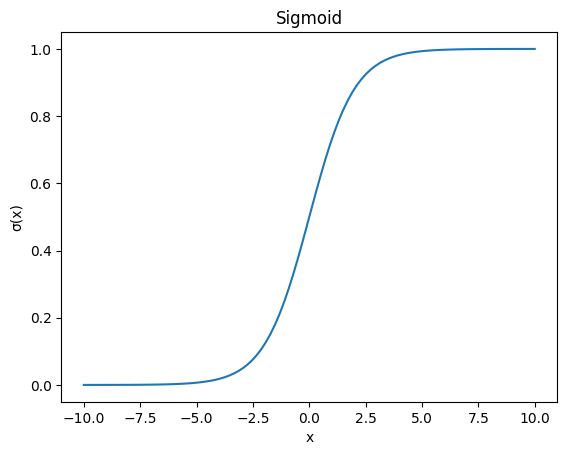

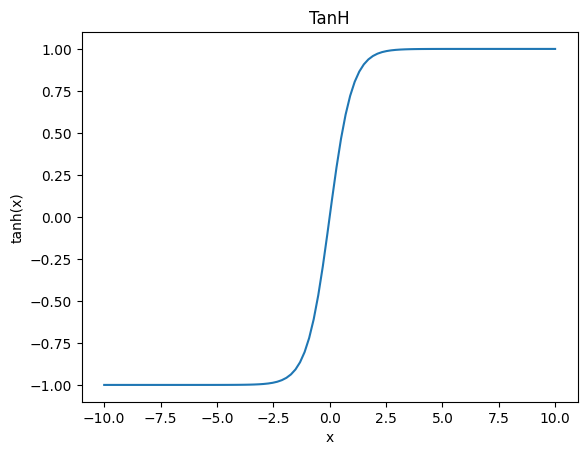

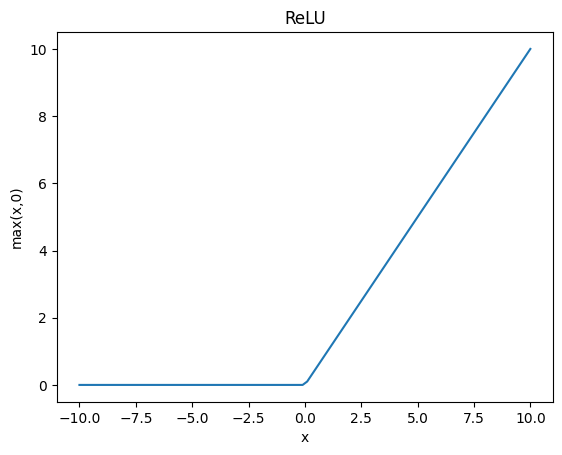

In [43]:
# Run this cell to see how different activation functions act on inputs.
# Note that they are all element-wise functions.

x = torch.linspace(-10, 10, 100)
# PyTorch gives activation functions as `nn.Module` classes or as `nn.functional` functions. Because they don't have parameters, either one is valid.
plt.plot(x, F.sigmoid(x))
plt.xlabel('x')
plt.ylabel('σ(x)')
plt.title("Sigmoid")
plt.show()
plt.plot(x, F.tanh(x))
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.title("TanH")
plt.show()
plt.plot(x, F.relu(x))
plt.xlabel('x')
plt.ylabel('max(x,0)')
plt.title("ReLU")
plt.show()

Ironically, the least nonlinear looking function: ReLU, is going to be our default choice for neural network activation functions.
While it doesn't seem very nonlinear, when given large input tensors, it is nonlinear enough.
ReLU doesn't saturate for x>0 (there's no horizontal assymptote) and its cheap to compute: `x[where x < 0] = 0; return x`.

Now implement a `DeepNetwork`, which is like our `StackedLinear` network, but with nonlinearities between its linear layers.
You can use `F.relu()` to apply a nonlinear activation, where `F` is an alias for `torch.nn.functional`, which the functional version PyTorch's neural network library.

In [44]:
class DeepNetwork(nn.Module):  # True deep NN with activation functions
    def __init__(self, input_feature_size, output_feature_size, hidden_size):
        super().__init__()

        # Create 3 linear layers just like in StackedLinear
        self.lin1 = LinearLayer(input_feature_size, hidden_size)
        self.lin2 = LinearLayer(hidden_size, hidden_size)
        self.lin3 = LinearLayer(hidden_size, output_feature_size)

    def forward(self, x):
        # Pass through the first layer, followed by ReLU activation
        x = self.lin1(x)
        x = F.relu(x)  # Apply activation after the first layer

        # Pass through the second layer, followed by ReLU activation
        x = self.lin2(x)
        x = F.relu(x)  # Apply activation after the second layer

        # Pass through the third layer (output layer), no activation after this layer
        x = self.lin3(x)

        return x

Now see how the activation functions help our `DeepNetwork` perform on the nonlinear problem. Initialize a `DeepNetwork` (with hidden size set to 64) and a `SGD` optimizer (learning rate of .01) and train your network for 1000 steps.

Step 1/1000, Loss: 0.6309174299240112
Step 2/1000, Loss: 0.40633293986320496
Step 3/1000, Loss: 0.3727850615978241
Step 4/1000, Loss: 0.36508122086524963
Step 5/1000, Loss: 0.3611156940460205
Step 6/1000, Loss: 0.3577828109264374
Step 7/1000, Loss: 0.354746550321579
Step 8/1000, Loss: 0.35196512937545776
Step 9/1000, Loss: 0.3492810130119324
Step 10/1000, Loss: 0.34676024317741394
Step 11/1000, Loss: 0.3443478047847748
Step 12/1000, Loss: 0.3420287072658539
Step 13/1000, Loss: 0.3397723436355591
Step 14/1000, Loss: 0.33757278323173523
Step 15/1000, Loss: 0.33542561531066895
Step 16/1000, Loss: 0.33330944180488586
Step 17/1000, Loss: 0.33122962713241577
Step 18/1000, Loss: 0.32925453782081604
Step 19/1000, Loss: 0.32732975482940674
Step 20/1000, Loss: 0.32544195652008057
Step 21/1000, Loss: 0.32356032729148865
Step 22/1000, Loss: 0.3216955065727234
Step 23/1000, Loss: 0.31986284255981445
Step 24/1000, Loss: 0.3180500268936157
Step 25/1000, Loss: 0.31626126170158386
Step 26/1000, Loss: 0

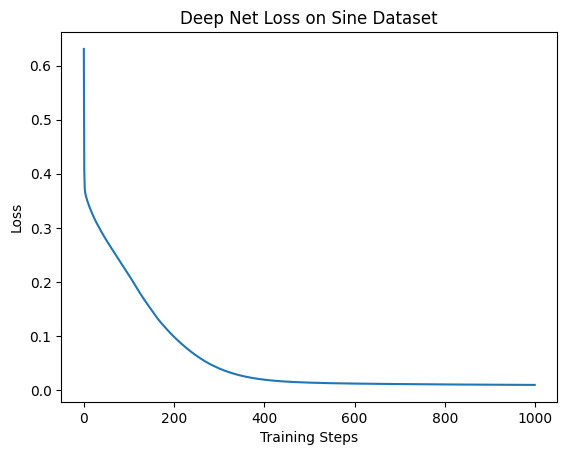

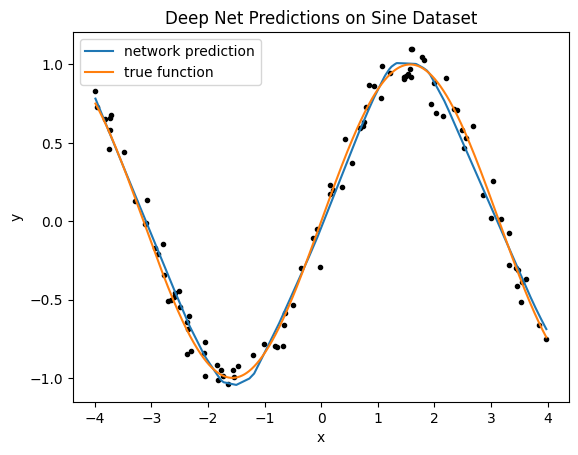

In [45]:
# Set random seed for reproducibility
torch.manual_seed(0)

# TODO: Initialize a DeepNetwork (set hidden_size to 64) called deep_net
input_feature_size = 1  # The input size (same as before)
output_feature_size = 1  # The output size (same as before)
hidden_size = 64  # Hidden size as hyperparameter

# Initialize the deep network
deep_net = DeepNetwork(input_feature_size=input_feature_size, output_feature_size=output_feature_size, hidden_size=hidden_size)

# TODO: Initialize an SGD optimizer with a learning rate of .01
optimizer = SGD(deep_net.parameters(), lr=0.01)

# TODO: Train deep_net for 1000 steps and store training losses
train_losses = train_with_loss_tracking(deep_net, optimizer, sine_x, sine_y, training_steps=1000)

# Plot the training losses
plot_loss(train_losses, "Deep Net Loss on Sine Dataset")

# Plot the network's predictions on the sine wave dataset
plot_data(sine_x, sine_y, deep_net, gt_func=torch.sin, title="Deep Net Predictions on Sine Dataset")


---
# `nn.Sequential`

As discussed, PyTorch has many useful classes in the `nn` library.

1. `nn.Linear` has the same functionality as your `LinearLayer`.
2. `nn.ReLU` is the `Module` version of `F.relu()`; it has no parameters, but it's forward function calls `F.relu()`.
3. `nn.Sequential` is a `Module` that chains together the `.forward()` outputs of a sequence of `Module`s.
For example, you can easily create a 2-layer neural network, with `net = nn.Sequential(nn.Linear(), nn.ReLU(), nn.Linear())` and instead of manually chaining the `.forward()` outputs of the 3 `Module`s, e.g. `linear(relu(linear(x)))`, the `nn.Sequential` object will automatically do it. `net(x)`.

Recreate `deep_net` using only `nn.Sequential`, `nn.Linear`, and `nn.ReLU`.
Train the new model using PyTorch's `torch.optim.SGD` optimizer.

Step 1/1000, Loss: 0.530926525592804
Step 2/1000, Loss: 0.485250860452652
Step 3/1000, Loss: 0.4534074366092682
Step 4/1000, Loss: 0.43071064352989197
Step 5/1000, Loss: 0.41398200392723083
Step 6/1000, Loss: 0.4014129638671875
Step 7/1000, Loss: 0.3916741907596588
Step 8/1000, Loss: 0.3839619755744934
Step 9/1000, Loss: 0.3777819871902466
Step 10/1000, Loss: 0.37270301580429077
Step 11/1000, Loss: 0.3683810532093048
Step 12/1000, Loss: 0.3646206557750702
Step 13/1000, Loss: 0.3612971901893616
Step 14/1000, Loss: 0.35829436779022217
Step 15/1000, Loss: 0.3555361032485962
Step 16/1000, Loss: 0.35292133688926697
Step 17/1000, Loss: 0.35043689608573914
Step 18/1000, Loss: 0.34803473949432373
Step 19/1000, Loss: 0.3457163870334625
Step 20/1000, Loss: 0.3434663414955139
Step 21/1000, Loss: 0.34126442670822144
Step 22/1000, Loss: 0.3390880227088928
Step 23/1000, Loss: 0.3369309902191162
Step 24/1000, Loss: 0.33482715487480164
Step 25/1000, Loss: 0.3327421247959137
Step 26/1000, Loss: 0.33066

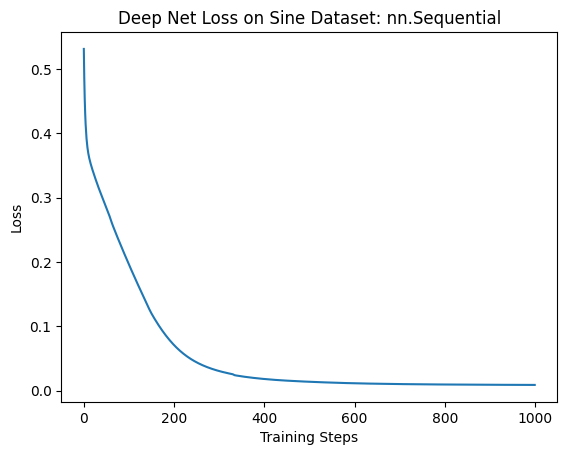

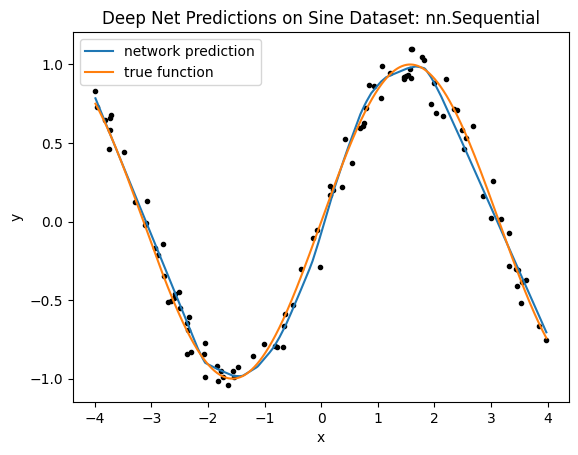

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim

# Set random seed for reproducibility
torch.manual_seed(0)

# TODO: Recreate deep_net using only `nn.Sequential`, `nn.Linear`, and `nn.ReLU`
deep_net = nn.Sequential(
    nn.Linear(1, 64),  # Input to hidden layer (B, 1) -> (B, 64)
    nn.ReLU(),         # Apply ReLU activation
    nn.Linear(64, 64), # Hidden layer to hidden layer (B, 64) -> (B, 64)
    nn.ReLU(),         # Apply ReLU activation
    nn.Linear(64, 1)   # Hidden layer to output layer (B, 64) -> (B, 1)
)

# TODO: Create a torch.optim.SGD optimizer for our new deep_net using a learning rate of 0.01
optimizer = optim.SGD(deep_net.parameters(), lr=0.01)

# TODO: Train deep_net for 1000 steps and store training losses
train_losses = train_with_loss_tracking(deep_net, optimizer, sine_x, sine_y, training_steps=1000)

# Plot training losses
plot_loss(train_losses, "Deep Net Loss on Sine Dataset: nn.Sequential")

# Plot the fit on the dataset
plot_data(sine_x, sine_y, deep_net, gt_func=torch.sin, title="Deep Net Predictions on Sine Dataset: nn.Sequential")
